In [1]:
# ============================================================
# 0. IMPORTS E CONFIGURAÇÕES BÁSICAS
# ============================================================
import os
import time
import copy
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import datasets, transforms, models
from torchvision.models import resnet18, ResNet18_Weights

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# Garantir reprodutibilidade (opcional)
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)



Device: cuda


In [2]:
# ============================================================
# 1. DOWNLOAD E PREPARO DO DATASET TRASHNET (dataset-resized)
# ============================================================

# 1.1 Baixar somente o dataset-resized (não o repositório inteiro)
!wget -O dataset-resized.zip "https://github.com/garythung/trashnet/raw/master/data/dataset-resized.zip"

# 1.2 Descompactar na pasta atual (/content)
!unzip -q dataset-resized.zip -d .

# 1.3 Definir caminho para o dataset
data_dir = "/content/dataset-resized"

# 1.4 Conferir estrutura do dataset
print("Existe a pasta dataset-resized?", os.path.isdir(data_dir))
print("Subpastas dentro de dataset-resized:", os.listdir(data_dir))

for cls in os.listdir(data_dir):
    cls_path = os.path.join(data_dir, cls)
    if os.path.isdir(cls_path):
        print(cls, "→", len(os.listdir(cls_path)), "imagens")

--2025-12-05 00:19:35--  https://github.com/garythung/trashnet/raw/master/data/dataset-resized.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/garythung/trashnet/master/data/dataset-resized.zip [following]
--2025-12-05 00:19:35--  https://raw.githubusercontent.com/garythung/trashnet/master/data/dataset-resized.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42834870 (41M) [application/zip]
Saving to: ‘dataset-resized.zip’

dataset-resized.zip 100%[===================>]  40.85M  --.-KB/s    in 0.07s   

2025-12-05 00:19:37 (575 MB/s) - ‘dataset-resized.zip’ saved [42834870/42834870]



In [3]:
# ============================================================
# 2. TRANSFORMS, DATASET E DATALOADERS
# ============================================================

input_size = 224  # tamanho padrão para ResNet

# Transforms para treino (com augmentation)
train_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Transforms para validação e teste (sem augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Dataset completo
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
class_names = full_dataset.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Total de imagens:", len(full_dataset))

# Split treino / val / teste (por exemplo 70 / 15 / 15)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

n_total = len(full_dataset)
n_train = int(train_ratio * n_total)
n_val = int(val_ratio * n_total)
n_test = n_total - n_train - n_val

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(42)
)

# Atualiza transform para val/test (sem augmentation)
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2)

dataloaders = {"train": train_loader, "val": val_loader}
dataset_sizes = {"train": len(train_dataset), "val": len(val_dataset)}

print(f"Tamanho treino: {dataset_sizes['train']}, val: {dataset_sizes['val']}, teste: {len(test_dataset)}")


Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Total de imagens: 2527
Tamanho treino: 1768, val: 379, teste: 380


In [4]:
# ============================================================
# 3. DEFINIÇÃO DO MODELO 1 – CNN SIMPLES
# ============================================================

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 224 -> 112

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 112 -> 56

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 56 -> 28
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

cnn_model = SimpleCNN(num_classes=num_classes).to(device)
print(cnn_model)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=100352, out_features=256, bias=Tr

In [5]:
# ============================================================
# 4. DEFINIÇÃO DO MODELO 2 – RESNET18 (TRANSFER LEARNING)
# ============================================================

# Carrega ResNet18 pré-treinada no ImageNet
resnet_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Congela todas as camadas, exceto a fully connected final
for param in resnet_model.parameters():
    param.requires_grad = False

# Substitui a última camada para o número de classes do TrashNet
in_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(in_features, num_classes)

resnet_model = resnet_model.to(device)
print(resnet_model.fc)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 238MB/s]


Linear(in_features=512, out_features=6, bias=True)


In [6]:
# ============================================================
# 5. FUNÇÃO GENÉRICA DE TREINO (PARA QUALQUER MODELO)
# ============================================================

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc.item())

            print(f"{phase} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f"\nTreino completo em {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Melhor acurácia em validação: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return model, history

In [7]:
# ============================================================
# 6. FUNÇÕES DE AVALIAÇÃO E PLOTS
# ============================================================

def evaluate_model(model, dataloader, class_names):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds  = np.array(all_preds)

    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="weighted", zero_division=0
    )

    print(f"Acurácia: {acc:.4f}")
    print(f"Precisão: {precision:.4f}")
    print(f"Recall:   {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    return acc, precision, recall, f1, cm


def plot_confusion_matrix(cm, class_names, title="Matriz de confusão"):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha="right")
    plt.yticks(tick_marks, class_names)

    fmt = "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("Classe verdadeira")
    plt.xlabel("Classe prevista")
    plt.tight_layout()
    plt.show()


def plot_history(history, title_prefix="Modelo"):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Treino")
    plt.plot(epochs, history["val_loss"], label="Validação")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} - Loss")
    plt.legend()

    # Acurácia
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Treino")
    plt.plot(epochs, history["val_acc"], label="Validação")
    plt.xlabel("Época")
    plt.ylabel("Acurácia")
    plt.title(f"{title_prefix} - Acurácia")
    plt.legend()

    plt.tight_layout()
    plt.show()



Epoch 1/10
------------------------------
train Loss: 1.6445  Acc: 0.4304
val Loss: 1.1498  Acc: 0.5541

Epoch 2/10
------------------------------
train Loss: 1.1607  Acc: 0.5667
val Loss: 1.0840  Acc: 0.6148

Epoch 3/10
------------------------------
train Loss: 1.0965  Acc: 0.5950
val Loss: 1.0180  Acc: 0.6332

Epoch 4/10
------------------------------
train Loss: 0.9961  Acc: 0.6465
val Loss: 0.9638  Acc: 0.6491

Epoch 5/10
------------------------------
train Loss: 0.8677  Acc: 0.6804
val Loss: 0.9323  Acc: 0.6728

Epoch 6/10
------------------------------
train Loss: 0.7970  Acc: 0.7053
val Loss: 0.9196  Acc: 0.6781

Epoch 7/10
------------------------------
train Loss: 0.6955  Acc: 0.7500
val Loss: 0.8597  Acc: 0.6728

Epoch 8/10
------------------------------
train Loss: 0.6431  Acc: 0.7658
val Loss: 0.9432  Acc: 0.6649

Epoch 9/10
------------------------------
train Loss: 0.5728  Acc: 0.7879
val Loss: 0.8709  Acc: 0.7098

Epoch 10/10
------------------------------
train Loss:

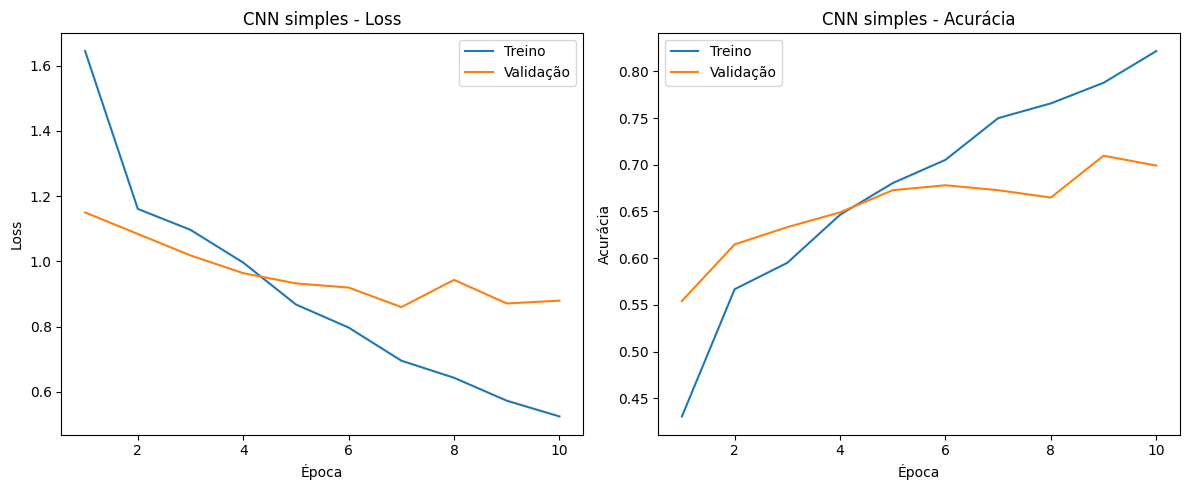


Avaliação da CNN simples no conjunto de teste:
Acurácia: 0.7289
Precisão: 0.7361
Recall:   0.7289
F1-score: 0.7231


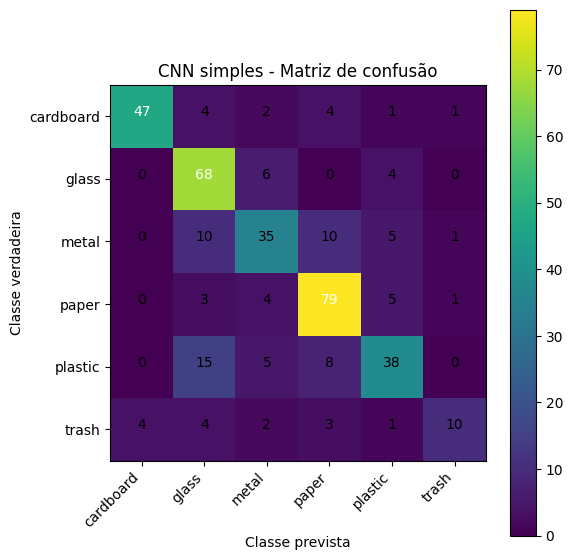

In [8]:
# ============================================================
# 7. TREINO DA CNN SIMPLES
# ============================================================

cnn_model = SimpleCNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=1e-4)

num_epochs_cnn = 10  # você pode reduzir para testar mais rápido

cnn_model, history_cnn = train_model(
    cnn_model,
    dataloaders,
    dataset_sizes,
    criterion,
    optimizer_cnn,
    num_epochs=num_epochs_cnn
)

plot_history(history_cnn, title_prefix="CNN simples")

print("\nAvaliação da CNN simples no conjunto de teste:")
acc_cnn, prec_cnn, rec_cnn, f1_cnn, cm_cnn = evaluate_model(
    cnn_model, test_loader, class_names
)
plot_confusion_matrix(cm_cnn, class_names, title="CNN simples - Matriz de confusão")

Número de parâmetros treináveis na ResNet18: 3078

Epoch 1/10
------------------------------
train Loss: 1.6883  Acc: 0.2579
val Loss: 1.6320  Acc: 0.2850

Epoch 2/10
------------------------------
train Loss: 1.5256  Acc: 0.4005
val Loss: 1.4887  Acc: 0.4011

Epoch 3/10
------------------------------
train Loss: 1.3968  Acc: 0.5068
val Loss: 1.3733  Acc: 0.4934

Epoch 4/10
------------------------------
train Loss: 1.2952  Acc: 0.5769
val Loss: 1.2834  Acc: 0.5515

Epoch 5/10
------------------------------
train Loss: 1.2032  Acc: 0.6182
val Loss: 1.2177  Acc: 0.6042

Epoch 6/10
------------------------------
train Loss: 1.1377  Acc: 0.6527
val Loss: 1.1383  Acc: 0.6227

Epoch 7/10
------------------------------
train Loss: 1.0638  Acc: 0.6782
val Loss: 1.0889  Acc: 0.6464

Epoch 8/10
------------------------------
train Loss: 1.0171  Acc: 0.7042
val Loss: 1.0460  Acc: 0.6649

Epoch 9/10
------------------------------
train Loss: 0.9771  Acc: 0.7189
val Loss: 0.9948  Acc: 0.6781

Epoc

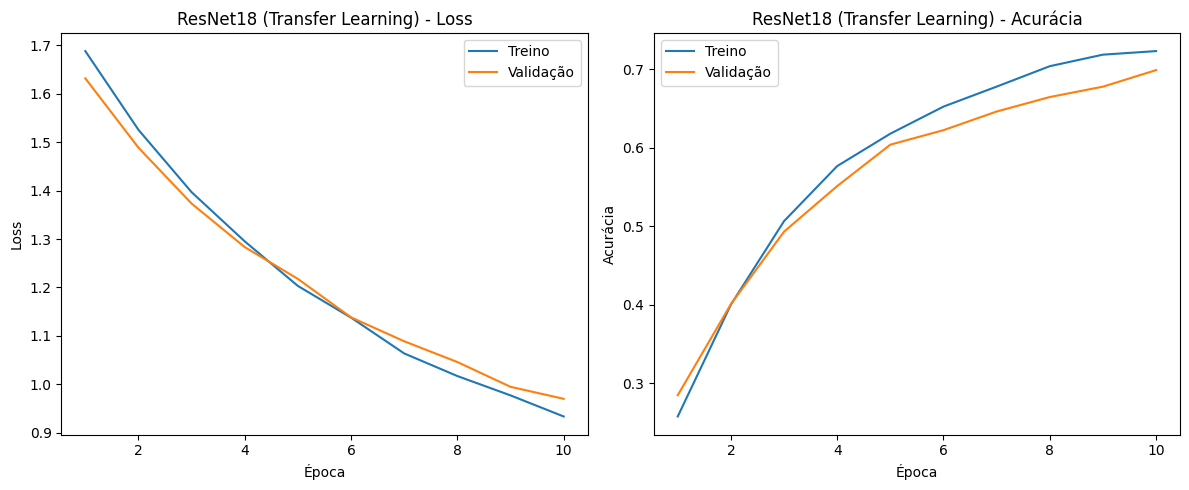


Avaliação da ResNet18 no conjunto de teste:
Acurácia: 0.7237
Precisão: 0.7165
Recall:   0.7237
F1-score: 0.7024


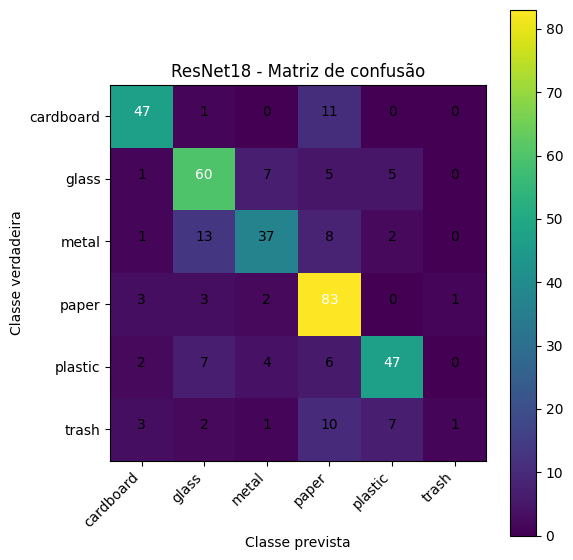

In [9]:
# ============================================================
# 8. TREINO DA RESNET18 (TRANSFER LEARNING)
# ============================================================

# Otimizamos apenas os parâmetros com requires_grad=True (a fc final)
params_to_update = [p for p in resnet_model.parameters() if p.requires_grad]
print("Número de parâmetros treináveis na ResNet18:", sum(p.numel() for p in params_to_update))

criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(params_to_update, lr=1e-4)

num_epochs_resnet = 10  # igual ou diferente do da CNN

resnet_model, history_resnet = train_model(
    resnet_model,
    dataloaders,
    dataset_sizes,
    criterion,
    optimizer_resnet,
    num_epochs=num_epochs_resnet
)

plot_history(history_resnet, title_prefix="ResNet18 (Transfer Learning)")

print("\nAvaliação da ResNet18 no conjunto de teste:")
acc_res, prec_res, rec_res, f1_res, cm_res = evaluate_model(
    resnet_model, test_loader, class_names
)
plot_confusion_matrix(cm_res, class_names, title="ResNet18 - Matriz de confusão")


In [10]:
# ============================================================
# 9. COMPARAÇÃO FINAL
# ============================================================

print("\n================= COMPARAÇÃO FINAL =================")
print("CNN simples:")
print(f"  Acurácia: {acc_cnn:.4f} | Precisão: {prec_cnn:.4f} | Recall: {rec_cnn:.4f} | F1: {f1_cnn:.4f}")

print("\nResNet18 (Transfer Learning):")
print(f"  Acurácia: {acc_res:.4f} | Precisão: {prec_res:.4f} | Recall: {rec_res:.4f} | F1: {f1_res:.4f}")
print("====================================================")



================= COMPARAÇÃO FINAL =================
CNN simples:
  Acurácia: 0.7289 | Precisão: 0.7361 | Recall: 0.7289 | F1: 0.7231

ResNet18 (Transfer Learning):
  Acurácia: 0.7237 | Precisão: 0.7165 | Recall: 0.7237 | F1: 0.7024
